# PROJEKT BOOTCAMP - PAWEŁ SEPIOŁ
Temat 1 Przewidywanie ceny domów. Celem projektu jest zastosowanie modeli regresji do przewidzenia ceny
domu o podanych cechach.

Link do danych: http://web.stanford.edu/class/stats191/data/ames2000_NAfix.csv

Dokładny opis danych: http://web.stanford.edu/class/stats191/data/amesdoc.txt

Zmienna celu (cena domu): SalePrice

Wymogi:
* Musi zostać wykorzystany model regresji liniowej.
* Muszą zostać wykorzystane przynajmniej dwie inne metody regresji: regresja Ridge, regresja Lasso, drzewo regresyjne, las losowy regresyjny, XGBoost lub inne).
* Trzeba uwzględnić optymalizację modeli/pipelinów.
* Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.
* Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięcie logarytmu ze zmiennej tym, że rozkład jest skośny).
* Musi pojawić się ocena graficzna predykcji modeli (np. wykresy wartości przewidywanych od prawdziwych czy wykresy reziduów).
* Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań (modeli/pipelinów) w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

# PLAN DZIAŁANIA

Wygląda na to, że po pierwszym sprawdzeniu vs oryginał dane zostały już poddane znacznej obróbce. Największą trudnością będzie opanowanie wielkości zbioru danych i ilości zmiennych.

Agenda:


Analiza danych wejściowych nieobrobionych
* Check funkcji celu vs intuicyjnie najlepsze zmienne numeryczne
* Sprawdzenie korelacji i wartości skarjnie odstających
* Sprawdzenie braków w danych
* Określenie wielkości braków i metody uzupełnienia ich

Opracowanie danych kategorycznych
* Wybranie zmiennych które można usunąć
* Ustalenie które zmienne można zastąpić zmienną binnarną (y/n w 0/1)
* Ustalenie które zmienne trzeba zamienić na wartości numeryczne
* Podmiana zmiennych zawierających wartościowanie na wartości numeryczne
* One hot encoding dla pozostałych zmiennych

Opracowanie danych numerycznych
* Analiza skośności i poprawa zmiennych w tym funkcji celu
* Opracowanie danych zawierających rok - cześć z nich najpewniej trzeba zamienić na kategorię i zrobić z nich osobne kolumny
* Korekta danych za pomocą logarytmów / pierwiastka / exp

Modelowanie
* Przygotowanie danych - kfoldy, podział na testową i treningową część
* Przygotowanie grid searchów i pipelinów pod modele
* Przebiegi i analiza wyników

Wyniki
* Ustalenie najlepszych modeli do prezentacji wyników
* Odtworzenie rzeczywistych błędów
* Porównanie z oryginalnymi wartościami

# BIBLIOTEKI

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import
import pandas as pd
import numpy  as np
import math
import xgboost

# Wykresy
import matplotlib.pyplot as plt
import seaborn as sns

# Skl
from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

# Modele i pipe
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

# DANE WEJŚCIOWE

In [3]:
# Konwersja danych .csv na dataframe po analizie zawartości pliku

url = 'http://web.stanford.edu/class/stats191/data/ames2000_NAfix.csv'

# Ze względu na ilosc kolumn w danych do analizy odkryjemy sobie możliwość podglądu wszystkich kolumn

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

data = pd.read_csv(url)
print(data.shape)

(2000, 80)


In [4]:
data.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MS.SubClass      2000 non-null   int64 
 1   MS.Zoning        2000 non-null   object
 2   Lot.Frontage     2000 non-null   object
 3   Lot.Area         2000 non-null   int64 
 4   Street           2000 non-null   object
 5   Alley            2000 non-null   object
 6   Lot.Shape        2000 non-null   object
 7   Land.Contour     2000 non-null   object
 8   Utilities        2000 non-null   object
 9   Lot.Config       2000 non-null   object
 10  Land.Slope       2000 non-null   object
 11  Neighborhood     2000 non-null   object
 12  Condition.1      2000 non-null   object
 13  Condition.2      2000 non-null   object
 14  Bldg.Type        2000 non-null   object
 15  House.Style      2000 non-null   object
 16  Overall.Qual     2000 non-null   int64 
 17  Overall.Cond     2000 non-null   

# OPIS DANYCH
Do wykorzystania przy analizie danych poniżej - pełne opisy w źródle

* Order (Discrete): Observation number
* PID (Nominal): Parcel identification number  - can be used with city web site for parcel review. 
* MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.
* MS Zoning (Nominal): Identifies the general zoning classification of the sale.
* Lot Frontage (Continuous): Linear feet of street connected to property
* Lot Area (Continuous): Lot size in square feet
* Street (Nominal): Type of road access to property      
* Alley (Nominal): Type of alley access to property
* Lot Shape (Ordinal): General shape of property      
* Land Contour (Nominal): Flatness of the property
* Utilities (Ordinal): Type of utilities available
* Lot Config (Nominal): Lot configuration
* Land Slope (Ordinal): Slope of property
* Neighborhood (Nominal): Physical locations within Ames city limits (map available)
* Condition 1 (Nominal): Proximity to various conditions
* Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
* Bldg Type (Nominal): Type of dwelling
* House Style (Nominal): Style of dwelling
* Overall Qual (Ordinal): Rates the overall material and finish of the house
* Overall Cond (Ordinal): Rates the overall condition of the house
* Year Built (Discrete): Original construction date
* Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
* Roof Style (Nominal): Type of roof
* Roof Matl (Nominal): Roof material
* Exterior 1 (Nominal): Exterior covering on house
* Exterior 2 (Nominal): Exterior covering on house (if more than one material)
* Mas Vnr Type (Nominal): Masonry veneer type
* Mas Vnr Area (Continuous): Masonry veneer area in square feet
* Exter Qual (Ordinal): Evaluates the quality of the material on the exterior 
* Exter Cond (Ordinal): Evaluates the present condition of the material on the exterior
* Foundation (Nominal): Type of foundation
* Bsmt Qual (Ordinal): Evaluates the height of the basement
* Bsmt Cond (Ordinal): Evaluates the general condition of the basement
* Bsmt Exposure
* BsmtFin Type 1
* BsmtFin SF 1 (Continuous): Type 1 finished square feet
* BsmtFinType 2
* BsmtFin SF 2 (Continuous): Type 2 finished square feet
* Bsmt Unf SF (Continuous): Unfinished square feet of basement area
* Total Bsmt SF (Continuous): Total square feet of basement area
* Heating
* HeatingQC (Ordinal): Heating quality and condition
* Central Air (Nominal): Central air conditioning
* Electrical (Ordinal): Electrical system
* 1st Flr SF (Continuous): First Floor square feet
* 2nd Flr SF (Continuous)
* Low Qual Fin SF (Continuous): Low quality finished square feet (all floors)
* Gr Liv Area (Continuous): Above grade (ground) living area square feet
* Bsmt Full Bath (Discrete): Basement full bathrooms
* Bsmt Half Bath (Discrete): Basement half bathrooms
* Full Bath (Discrete): Full bathrooms above grade
* Half Bath (Discrete): Half baths above grade
* Bedroom (Discrete): Bedrooms above grade (does NOT include basement bedrooms)
* Kitchen (Discrete): Kitchens above grade
* KitchenQual (Ordinal): Kitchen quality    
* TotRmsAbvGrd
* Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)
* Fireplaces (Discrete): Number of fireplaces
* FireplaceQu (Ordinal): Fireplace quality
* Garage Type (Nominal): Garage location
* Garage Yr Blt (Discrete): Year garage was built
* Garage Finish (Ordinal)
* Garage Cars (Discrete): Size of garage in car capacity
* Garage Area (Continuous): Size of garage in square feet
* Garage Qual (Ordinal): Garage quality
* Garage Cond (Ordinal): Garage condition
* Paved Drive (Ordinal): Paved driveway
* Wood Deck SF (Continuous): Wood deck area in square feet
* Open Porch SF (Continuous): Open porch area in square feet
* Enclosed Porch (Continuous): Enclosed porch area in square feet
* 3-Ssn Porch (Continuous): Three season porch area in square feet
* Screen Porch (Continuous): Screen porch area in square feet
* Pool Area (Continuous): Pool area in square feet
* Pool QC (Ordinal): Pool quality
* Fence (Ordinal): Fence quality
* Misc Feature (Nominal): Miscellaneous feature not covered in other categories
* Misc Val (Continuous): Value of miscellaneous feature
* Mo Sold (Discrete): Month Sold (MM)
* Yr Sold (Discrete): Year Sold (YYYY)
* Sale Type (Nominal): Type of sale
* Sale Condition (Nominal): Condition of sale
* SalePrice (Continuous): Sale price

# ANALIZA FUNKCJI WYNIKOWEJ

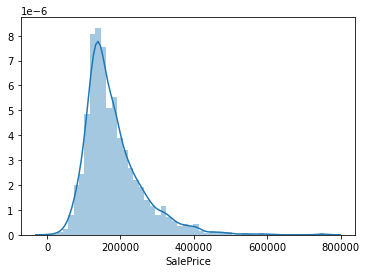

In [6]:
sns.distplot(data['SalePrice']);

In [7]:
data['SalePrice'].describe()
print("Skew: %f" % data['SalePrice'].skew())
print("Kurt: %f" % data['SalePrice'].kurt())

Skew: 1.738453
Kurt: 5.353734


Pierwszy rzut oka mówi o skośności rozkładu - skorygujemy go na przyszłośc pod analizy, idealnie układa się pod użycie logarytmu na danych.
Ulatwi też badanie korelacji między zmiennymi numerycznymi.

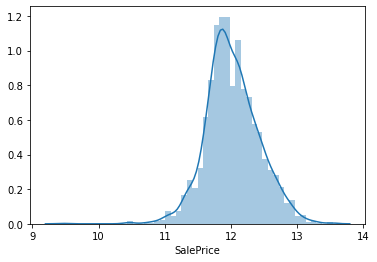

In [8]:
data['SalePrice'] = np.log(data['SalePrice'])
sns.distplot(data['SalePrice']);

In [9]:
data['SalePrice'].describe()

count    2000.000000
mean       12.020398
std         0.400634
min         9.456341
25%        11.767568
50%        11.982929
75%        12.271357
max        13.534473
Name: SalePrice, dtype: float64

Sprawdźmy korelację pomiędzy danymi numerycznymi

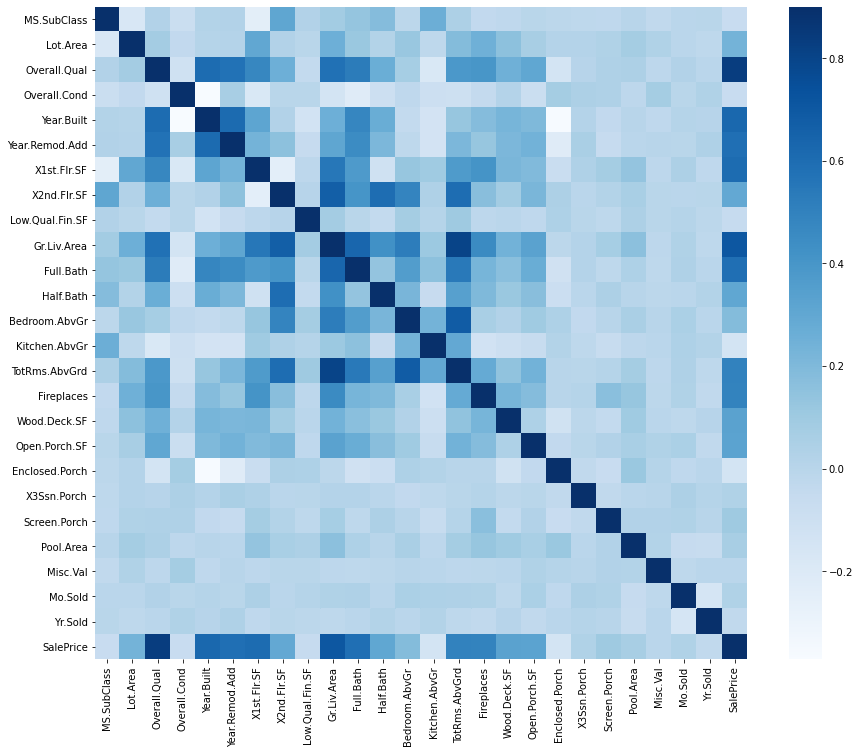

In [10]:
corr = data.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [11]:
data['SalePrice'].describe()

count    2000.000000
mean       12.020398
std         0.400634
min         9.456341
25%        11.767568
50%        11.982929
75%        12.271357
max        13.534473
Name: SalePrice, dtype: float64

Przyjrzyjmy się teraz najbardziej skorelowanymi parametrami czyli ogólna jakość, rok budowy, metraż (w tym metraż per piętro)

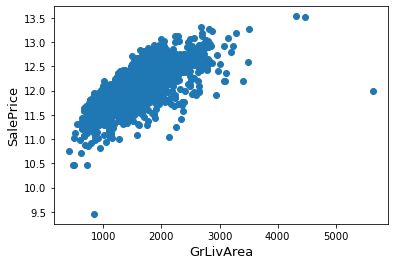

In [12]:
fig, ax = plt.subplots()
ax.scatter(x = data['Gr.Liv.Area'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Naprawmy te dane od razu, wykluczmy outliery zrównując je do 3500 oraz cene do 10,5

In [13]:
data[data['Gr.Liv.Area']>3500]

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
580,60,RL,104,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,1,2007,WD,Normal,13.534473
1233,60,RL,313,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,None,None,0,1,2008,New,Partial,11.982929
1541,60,RL,160,15623,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,13.521139


In [14]:
data.loc[data['Gr.Liv.Area'] >3500, 'Gr.Liv.Area'] = 3500

In [15]:
data[data['SalePrice']<10.5]

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
680,20,C (all),50,9000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,TA,N,FuseA,480,0,0,480,1,0,0,0,1,1,TA,4,Typ,0,None,Detchd,1958,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,10,2006,WD,Abnorml,10.471950
960,30,RL,60,8088,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,2,3,1922,1955,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,498,498,GasA,TA,N,FuseF,498,0,0,498,0,0,1,0,1,1,TA,3,Typ,0,None,Detchd,1922,Unf,1,216,Fa,Fa,N,0,0,100,0,0,0,None,None,None,0,2,2006,ConLD,Normal,10.463103
1253,30,RM,68,9656,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0,TA,Fa,BrkTil,Fa,Fa,No,Unf,0,Unf,0,678,678,GasA,TA,N,SBrkr,832,0,0,832,0,0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1928,Unf,2,780,Fa,Fa,N,0,0,0,0,0,0,None,None,None,0,6,2010,WD,Abnorml,9.456341
1718,30,C (all),60,7879,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,TA,N,FuseA,720,0,0,720,0,0,1,0,2,1,TA,4,Typ,0,None,None,None,None,0,0,None,None,N,0,523,115,0,0,0,None,GdWo,None,0,11,2009,WD,Abnorml,10.460242


In [16]:
data.loc[data['SalePrice'] <10.5, 'SalePrice'] = 10.5

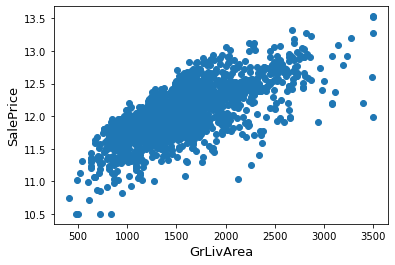

In [17]:
fig, ax = plt.subplots()
ax.scatter(x = data['Gr.Liv.Area'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

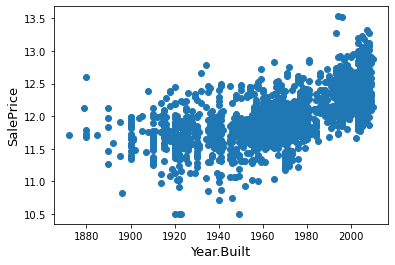

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = data['Year.Built'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Year.Built', fontsize=13)
plt.show()

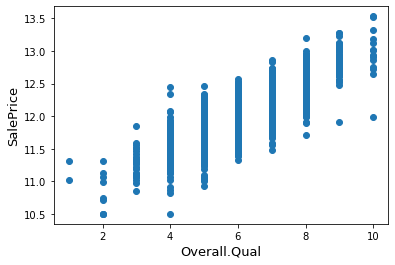

In [19]:
fig, ax = plt.subplots()
ax.scatter(x = data['Overall.Qual'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Overall.Qual', fontsize=13)
plt.show()

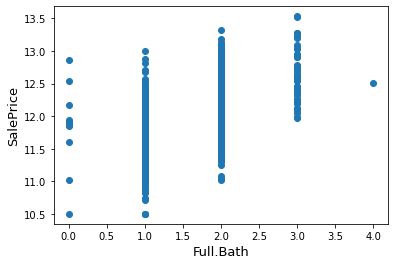

In [20]:
fig, ax = plt.subplots()
ax.scatter(x = data['Full.Bath'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Full.Bath', fontsize=13)
plt.show()

Potencjalnie widac problem przy rekordach odstających dla metrażu, najpewniej to pojedyncze sprzedaże ogromnych domów.
Można by je usunąć ale przy założeniach projektu skorygujemy je w dół do wartości bliższych reszcie danych.

Pozostałe dane zachowują się intuicyjnie, cena rośnie wraz ze wzrostem jakości, metrażu, rokiem budowy i ilością łazienek.

# UZUPELNIENIE BRAKOW

Komentarz: mamy braki jedynie dla danych kategorycznych, przyjrzyjmy się im

In [21]:
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Mas.Vnr.Type,0.80
Bsmt.Exposure,0.15
Garage.Finish,0.10
BsmtFin.Type.2,0.10
Garage.Cond,0.05
Garage.Qual,0.05
BsmtFin.Type.1,0.05
Bsmt.Cond,0.05
Bsmt.Qual,0.05


Są bardzo niewielkie ilości brakujących elementów, nie musimy sprawdzać poprawności merytoryki uzupełnianych wartości - o ile poprawiło by to wynik modelu róznice są niematerialne

In [22]:
data['Mas.Vnr.Type'].value_counts()

None       1216
BrkFace     593
Stone       159
BrkCmn       15
CBlock        1
Name: Mas.Vnr.Type, dtype: int64

In [23]:
data['Mas.Vnr.Type'] = data['Mas.Vnr.Type'].fillna('None')

In [24]:
data['Bsmt.Exposure'].value_counts()

No      1306
Av       285
Gd       188
Mn       166
None      52
Name: Bsmt.Exposure, dtype: int64

In [25]:
data['Bsmt.Exposure'] = data['Bsmt.Exposure'].fillna('No')

In [26]:
data['Garage.Finish'].value_counts()

Unf     831
RFn     578
Fin     479
None    110
Name: Garage.Finish, dtype: int64

In [27]:
data['Garage.Finish'] = data['Garage.Finish'].fillna('Unf')

In [28]:
data['BsmtFin.Type.2'].value_counts()

Unf     1694
Rec       70
LwQ       67
None      52
BLQ       50
ALQ       38
GLQ       27
Name: BsmtFin.Type.2, dtype: int64

In [29]:
data['BsmtFin.Type.2'] = data['BsmtFin.Type.2'].fillna('Unf')

In [30]:
data['Garage.Cond'].value_counts()

TA      1816
None     111
Fa        53
Gd         9
Po         8
Ex         2
Name: Garage.Cond, dtype: int64

In [31]:
data['Garage.Cond'] = data['Garage.Cond'].fillna('TA')

In [32]:
data['Garage.Qual'].value_counts()

TA      1785
None     111
Fa        84
Gd        16
Po         2
Ex         1
Name: Garage.Qual, dtype: int64

In [33]:
data['Garage.Qual'] = data['Garage.Qual'].fillna('TA')

In [34]:
data['BsmtFin.Type.1'].value_counts()

GLQ     584
Unf     565
ALQ     293
Rec     204
BLQ     195
LwQ     106
None     52
Name: BsmtFin.Type.1, dtype: int64

In [35]:
data['BsmtFin.Type.1'] = data['BsmtFin.Type.1'].fillna('GLQ')

In [36]:
data['Bsmt.Cond'].value_counts()

TA      1783
Gd        88
Fa        71
None      52
Ex         3
Po         2
Name: Bsmt.Cond, dtype: int64

In [37]:
data['Bsmt.Cond'] = data['Bsmt.Cond'].fillna('TA')

In [38]:
data['Bsmt.Qual'].value_counts()

TA      892
Gd      837
Ex      163
Fa       54
None     52
Po        1
Name: Bsmt.Qual, dtype: int64

In [39]:
data['Bsmt.Qual'] = data['Bsmt.Qual'].fillna('TA')

Check:

In [40]:
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


Komentarz - normalnie powinniśmy zobaczyć, czy uzupełnianie najczęasciej występującymi wartościami ma sens merytoryczny - przy brakach 1-2 wartości na 2000 nie będzie miało dużego wpływu na model

# DANE KATEGORYCZNE

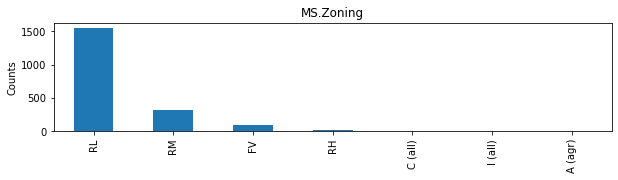

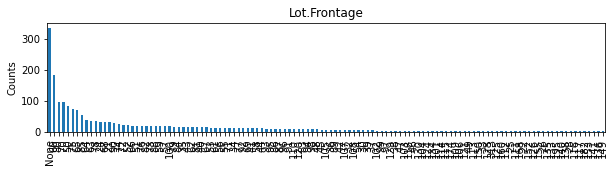

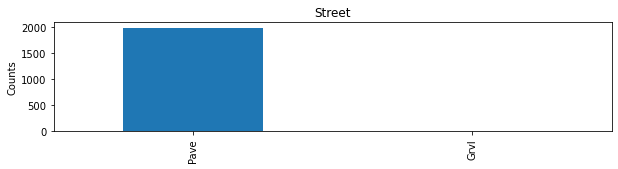

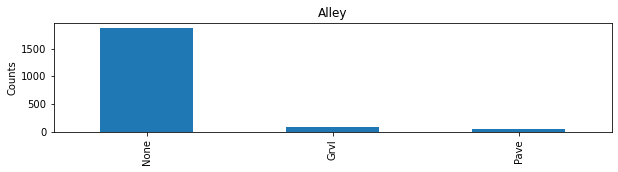

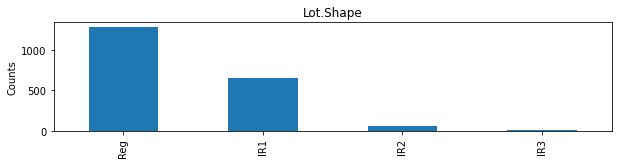

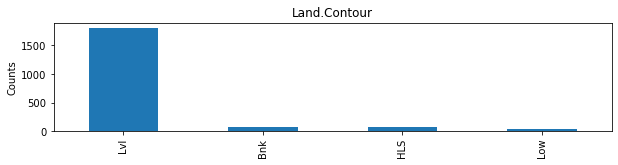

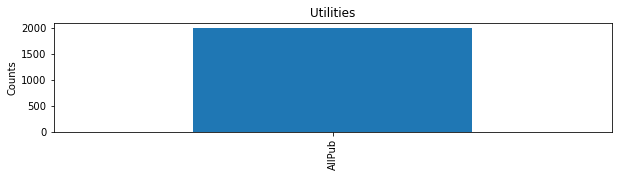

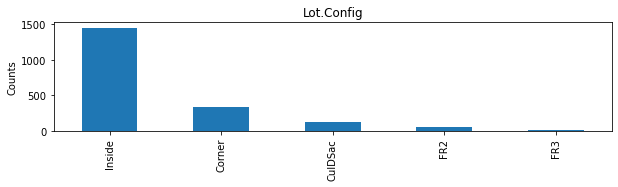

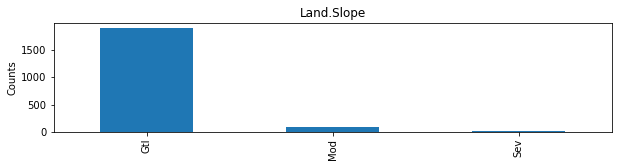

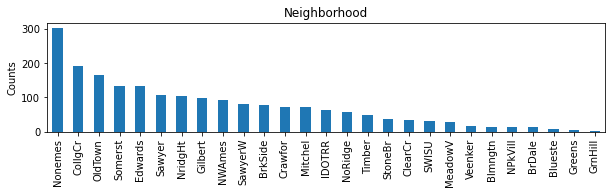

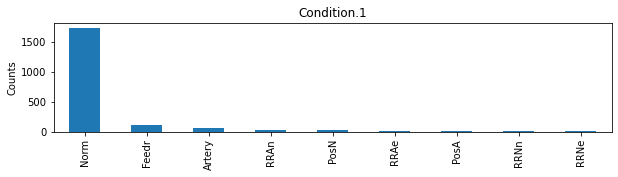

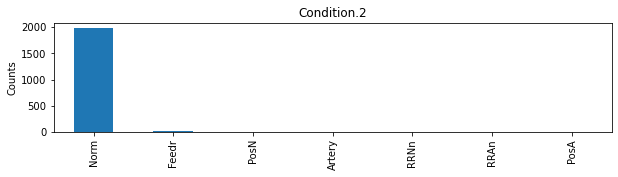

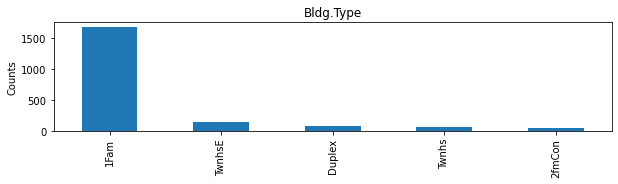

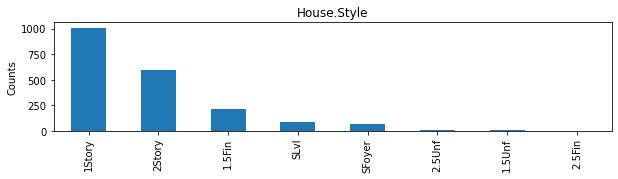

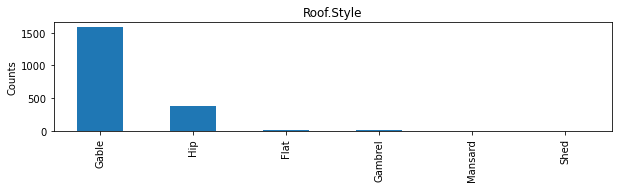

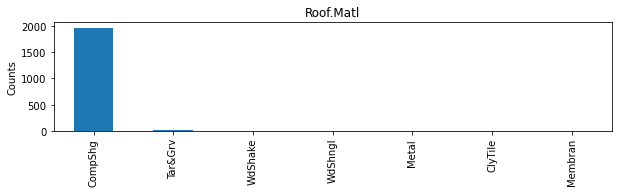

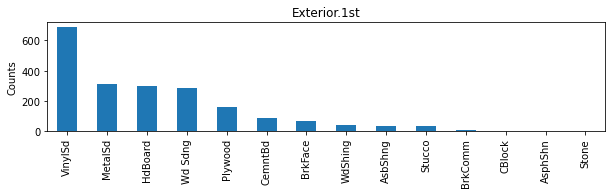

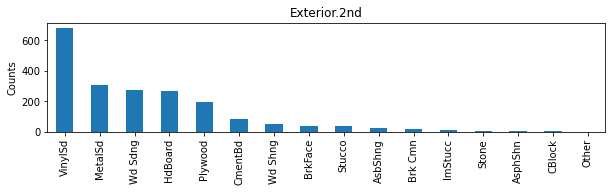

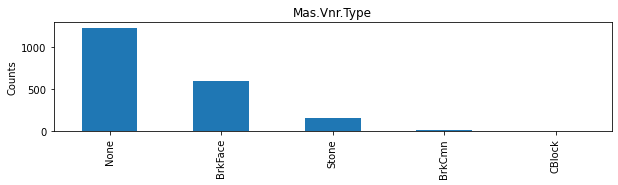

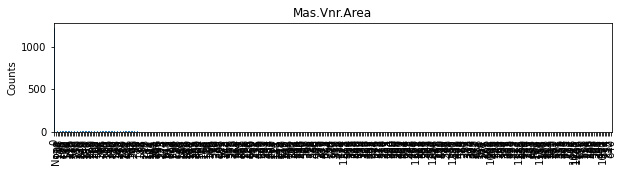

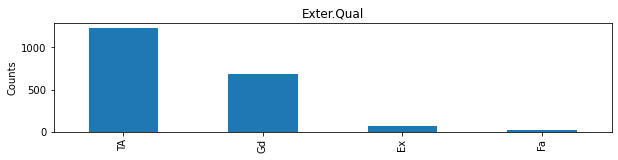

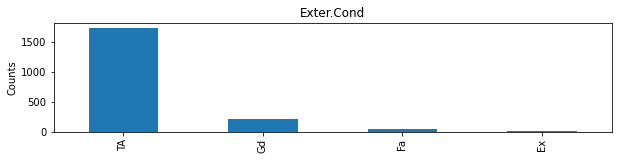

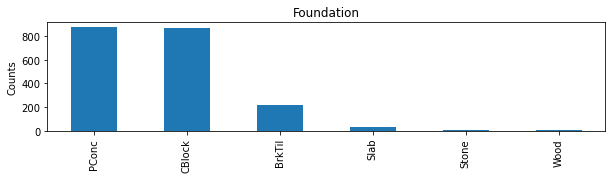

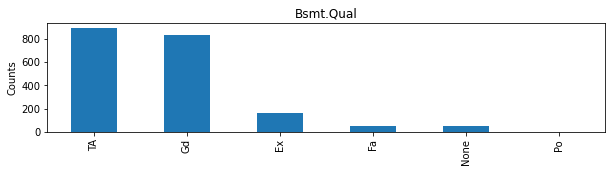

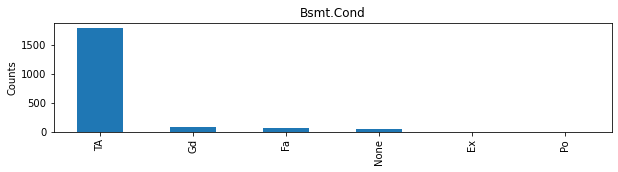

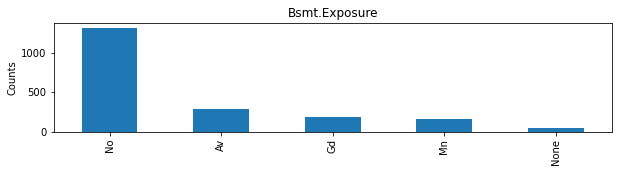

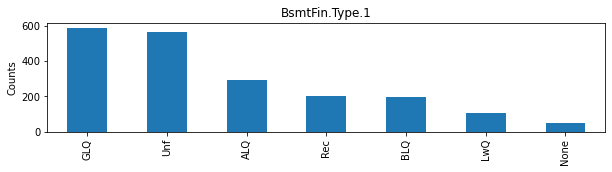

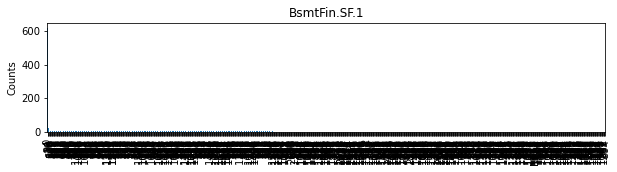

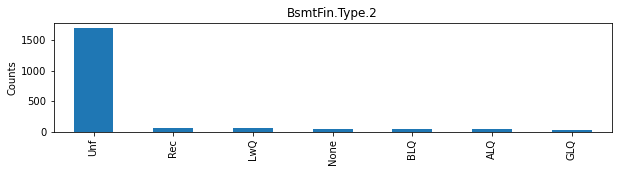

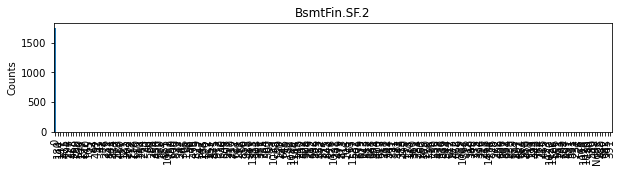

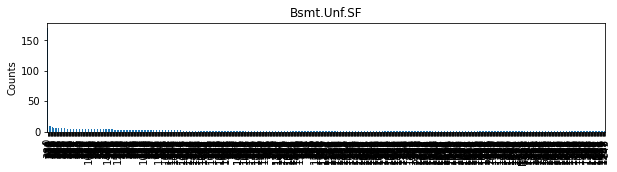

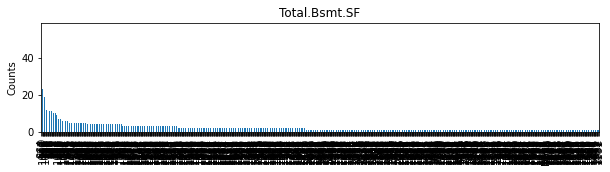

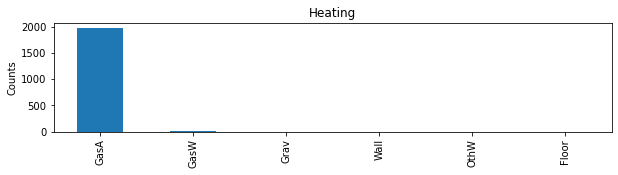

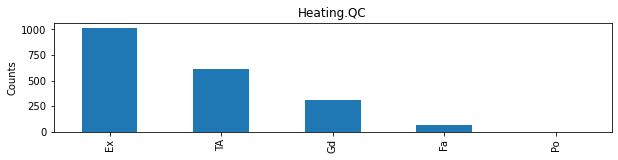

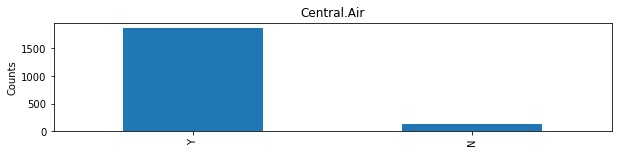

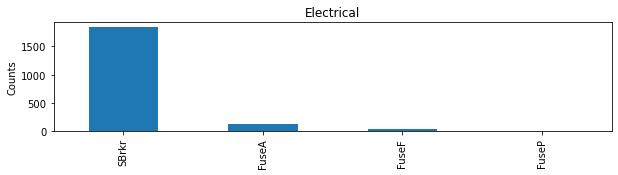

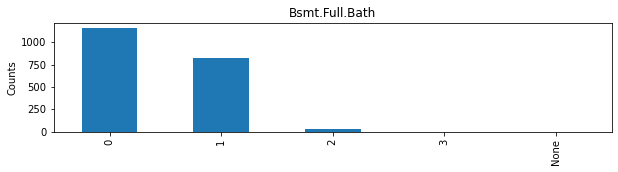

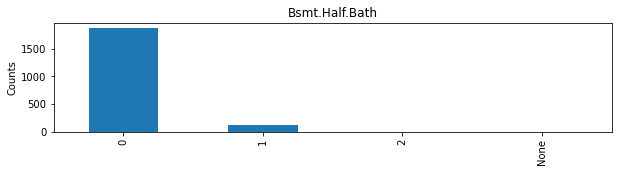

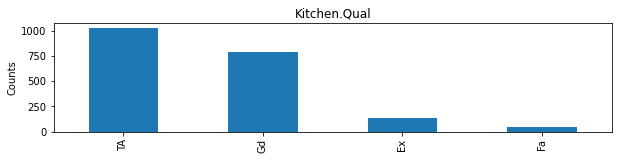

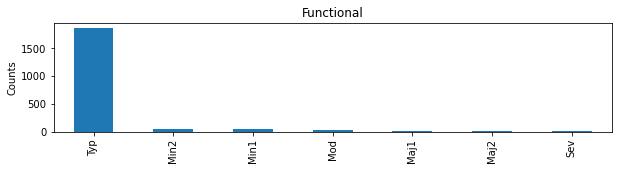

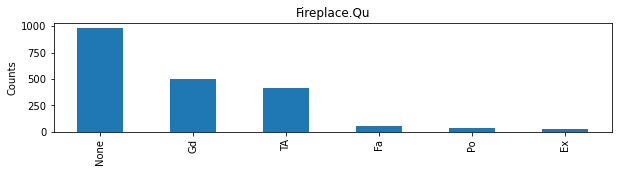

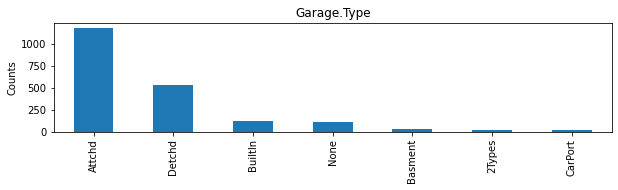

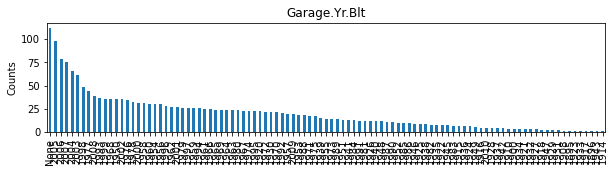

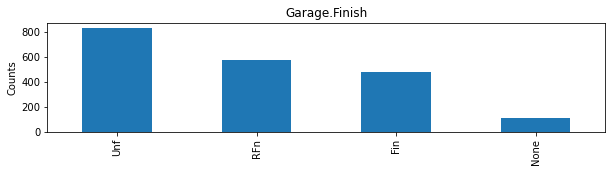

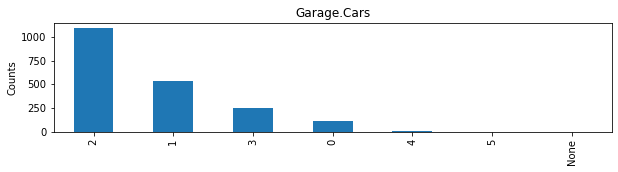

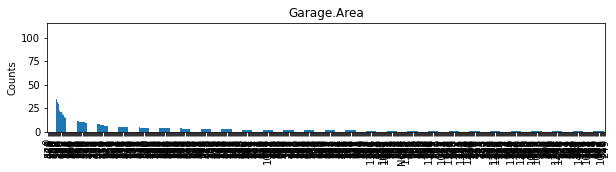

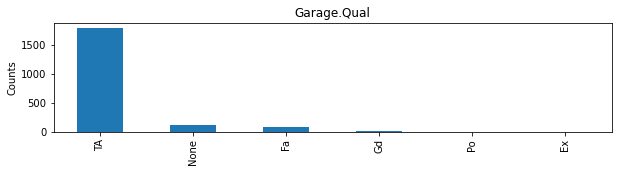

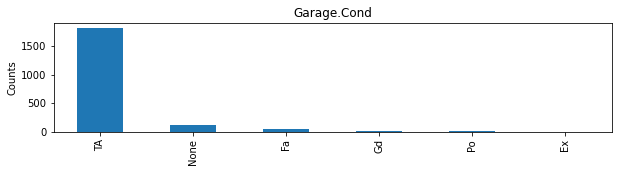

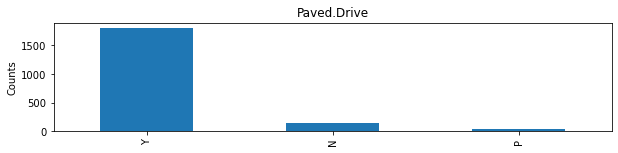

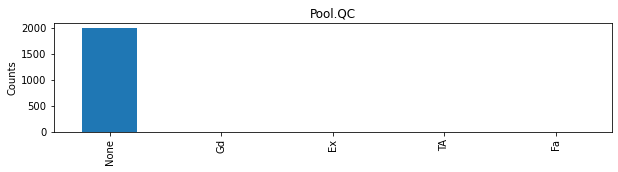

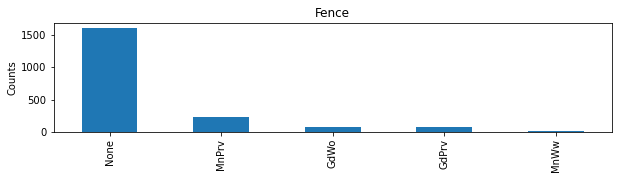

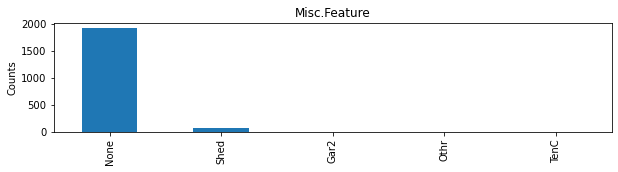

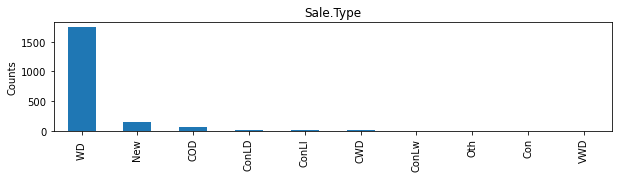

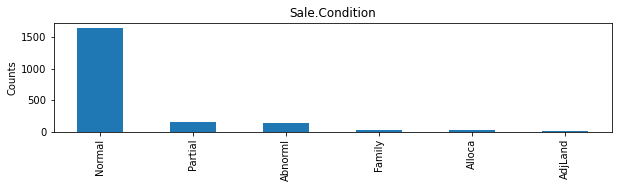

In [41]:
data_cat = data.select_dtypes(include=['object']).columns

for col in data_cat:
    data[col].value_counts().plot(kind='bar', title=col,figsize=(10, 2))
    plt.ylabel("Counts")
    plt.show()


Komentarz: widac wiele problemów z danymi - cześć danych kategorycznych można zakodowac w numeryczne, częśc trzeba jak np garage area gdzie dane ciągle sa przechowywane jako object - bedziemy sie posilkowac przy tym opisami dla danych

Zmienne gdzie wystąpują tylko 2 wartości zamienimy na 0/1 analogicznie gdy jest jedna przeważająca wartości zmienimy ją na 1 i resztę na 0.

Tam gdzie w opisie danych jest skala zmienimy na wartości numeryczne w skali 0-5 lub 0-10.

Zmienne gdzie występuje bardzo wiele wartości usuniemy gdy będą zawierały dane trudne do ocenienia merytorycznego i modelowego (np nazwa ulicy, id)

In [42]:
# Zaczynamy od konwersji na numeryczne zmiennych ciągłych - pomozemy sobie funkcja

In [43]:
def zamien_na_ciagle(name):
    data.loc[data[name] == 'None', name] = 0
    data[name] = data[name].astype(int)
    fig, ax = plt.subplots()
    ax.scatter(x = data[name], y = data['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(name, fontsize=13)
    plt.show()

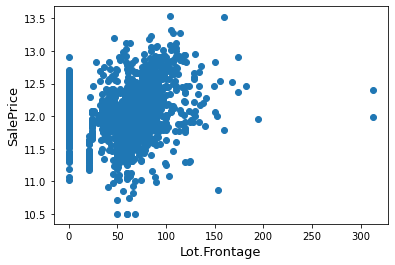

In [44]:
zamien_na_ciagle('Lot.Frontage')

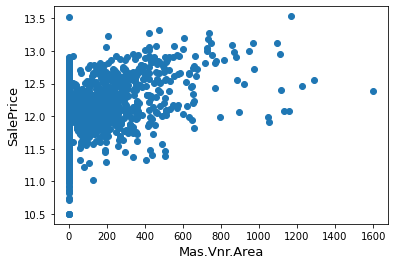

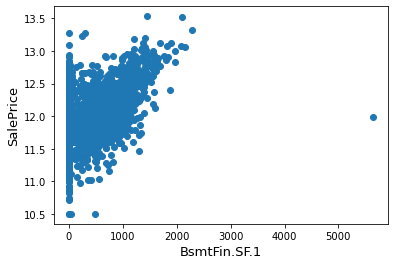

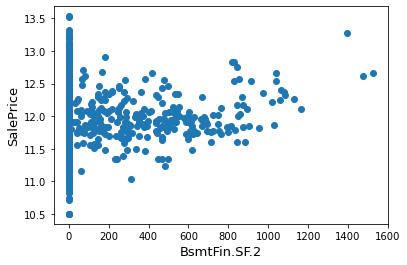

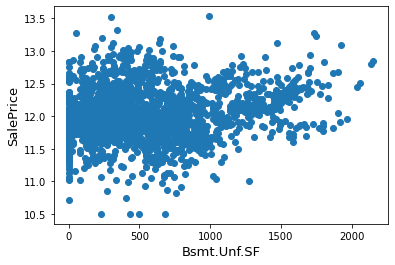

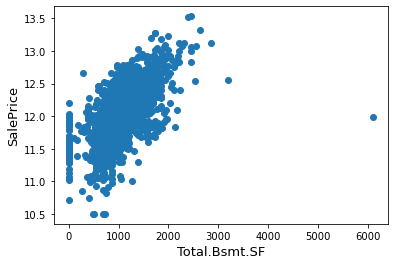

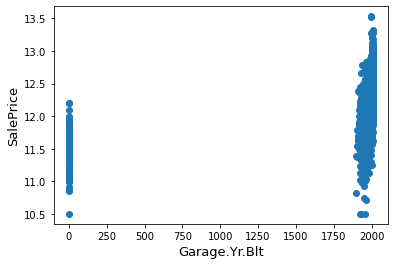

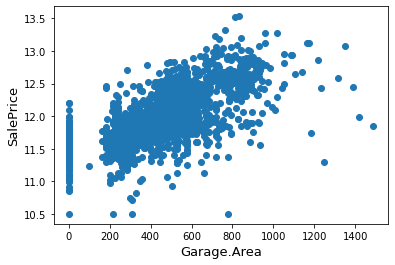

In [45]:
zamien_na_ciagle('Mas.Vnr.Area')
zamien_na_ciagle('BsmtFin.SF.1')
zamien_na_ciagle('BsmtFin.SF.2')
zamien_na_ciagle('Bsmt.Unf.SF')
zamien_na_ciagle('Total.Bsmt.SF')
zamien_na_ciagle('Garage.Yr.Blt')
zamien_na_ciagle('Garage.Area')

Bardzo niewielkie ilości outlierów - możemy zostawić bez dużej utraty jakości danych. Robimy tak tylko dlatego, że widząc już wstępnie skośność rozkładów będziemy je później korygować / skalować.

In [46]:
data.loc[data['BsmtFin.SF.1'] > 5000, 'BsmtFin.SF.1'] = 2000

In [47]:
srednia_rok_garaz = data[data['Garage.Yr.Blt'] != 0]
srednia_rok_garaz['Garage.Yr.Blt'].mean()
data.loc[data['Garage.Yr.Blt'] == 0, 'Garage.Yr.Blt'] = 1978

Check danych dataframe - upewnijmy się, że mamy wprowadzane zmiany pod kontrolą

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS.SubClass      2000 non-null   int64  
 1   MS.Zoning        2000 non-null   object 
 2   Lot.Frontage     2000 non-null   int32  
 3   Lot.Area         2000 non-null   int64  
 4   Street           2000 non-null   object 
 5   Alley            2000 non-null   object 
 6   Lot.Shape        2000 non-null   object 
 7   Land.Contour     2000 non-null   object 
 8   Utilities        2000 non-null   object 
 9   Lot.Config       2000 non-null   object 
 10  Land.Slope       2000 non-null   object 
 11  Neighborhood     2000 non-null   object 
 12  Condition.1      2000 non-null   object 
 13  Condition.2      2000 non-null   object 
 14  Bldg.Type        2000 non-null   object 
 15  House.Style      2000 non-null   object 
 16  Overall.Qual     2000 non-null   int64  
 17  Overall.Cond  

Widać brak nulli i ilość zmienionych kolumn danych na łatwe do użycia przez modele regresji

In [49]:
rozklad = data.describe(include=['int64','int32']).T
nulle = pd.DataFrame(data.isna().sum())
nulle.columns = ["null"]
rozklad = rozklad.join(nulle)
rozklad

,count,mean,std,min,25%,50%,75%,max,null
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0,0
Lot.Frontage,2000.0,57.8415,33.748020,0.0,43.00,63.0,78.00,313.0,0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0,0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0,0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0,0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0,0
Year.Remod.Add,2000.0,1984.0135,20.881771,1950.0,1965.00,1993.0,2004.00,2010.0,0
Mas.Vnr.Area,2000.0,99.1760,179.360629,0.0,0.00,0.0,153.00,1600.0,0
BsmtFin.SF.1,2000.0,441.9010,436.582226,0.0,0.00,375.0,736.00,2288.0,0
BsmtFin.SF.2,2000.0,52.6920,174.765791,0.0,0.00,0.0,0.00,1526.0,0


Z finalnymi zmianami zmiennych poczekajmy na uzupełnienie pozostałymi featursami

# ZAMIANA NA ZMIENNE BINARNE

Analizujemy które zmienne możemy spokojnie zastąpić jedną kolumną danych numerycznych - dane yes/no zmienimy na 0/1, zmienne łatwe do oszacowania pod względem oceny jakości zmienimy na skalę ocen.

Zależy nam by nie potrzebnie nie mnożyć zmiennych - rozbijmy tylko te dane kategoryczne na osobne kolumny one hot encoderem, gdzie faktycznie pomoże to w jakości modelu.

In [50]:
column_obj_kat = data.select_dtypes(include=['object']).columns

for col in column_obj_kat:
    if data[col].value_counts().shape[0] == 2 :
        print(data[col].value_counts(sort=False))

Grvl       8
Pave    1992
Name: Street, dtype: int64
Y    1873
N     127
Name: Central.Air, dtype: int64


In [51]:
column_obj_kat = data.select_dtypes(include=['object']).columns

for col in column_obj_kat:
    if data[col].value_counts().shape[0] == 3 :
        print(data[col].value_counts(sort=False))

None    1865
Grvl      85
Pave      50
Name: Alley, dtype: int64
Sev      14
Mod      86
Gtl    1900
Name: Land.Slope, dtype: int64
Y    1809
P      46
N     145
Name: Paved.Drive, dtype: int64


In [52]:
data['Street'].replace({'Grvl':0, 'Pave':1}, inplace=True) # merytrycznie ok bo lepsza utwardzona droga
data['Central.Air'].replace({'N':0, 'Y':1}, inplace=True)

In [53]:
data['Alley'].replace({'None':0,'Grvl':1, 'Pave':2}, inplace=True) # merytrycznie ok bo im ostrzej tym gorzej cos zmienic
data['Land.Slope'].replace({'Sev':0,'Mod':1, 'Gtl':2}, inplace=True) # merytrycznie ok bo im ostrzej tym gorzej cos zmienic
data['Paved.Drive'].replace({'N':0,'P':1, 'Y':2}, inplace=True) # najlepsza utwardzana droga, czesciowo w srodku, żwir koniec

In [54]:
column_obj_kat = data.select_dtypes(include=['object']).columns

for col in column_obj_kat:
    if data[col].value_counts().shape[0] == 4 :
        print(data[col].value_counts(sort=False))

IR2      55
IR3      13
Reg    1275
IR1     657
Name: Lot.Shape, dtype: int64
Low      42
Bnk      75
Lvl    1809
HLS      74
Name: Land.Contour, dtype: int64
Fa      21
TA    1230
Gd     683
Ex      66
Name: Exter.Qual, dtype: int64
Fa      40
TA    1734
Gd     218
Ex       8
Name: Exter.Cond, dtype: int64
SBrkr    1837
FuseF      37
FuseP       4
FuseA     122
Name: Electrical, dtype: int64
1        125
None       1
0       1870
2          4
Name: Bsmt.Half.Bath, dtype: int64
Fa      50
TA    1025
Gd     785
Ex     140
Name: Kitchen.Qual, dtype: int64
Unf     833
None    110
RFn     578
Fin     479
Name: Garage.Finish, dtype: int64


In [55]:
data['Lot.Shape'].replace({'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0}, inplace=True) #skala regularności mieszkania

# Tutaj skorygujemy jedynie te zmienne które maja skalę wartości z description

data['Exter.Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Exter.Cond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Bsmt.Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Bsmt.Cond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Bsmt.Exposure'].replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
data['Heating.QC'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Kitchen.Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Garage.Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Garage.Cond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
data['Pool.QC'].replace({'NA':0, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

Zamiennmy je na zmienne numeryczne i sprawdzmy czy nie widzimy tu bledow logicznych / technicznych

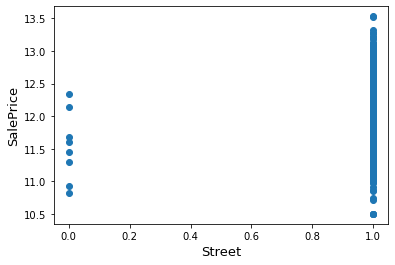

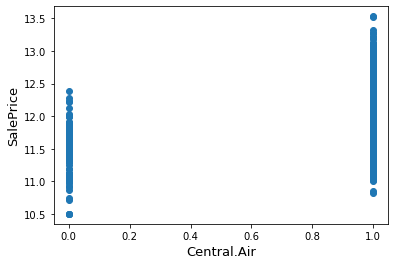

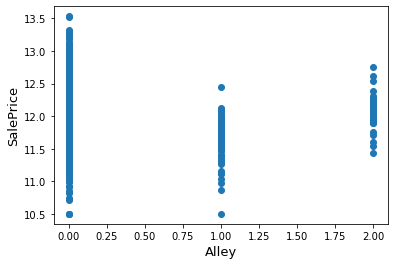

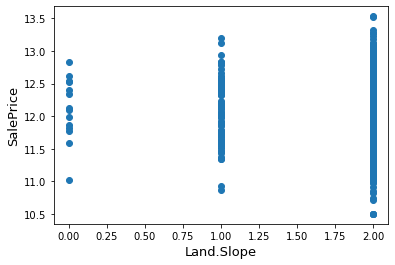

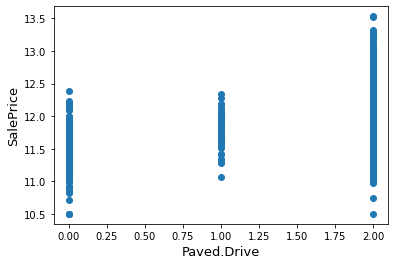

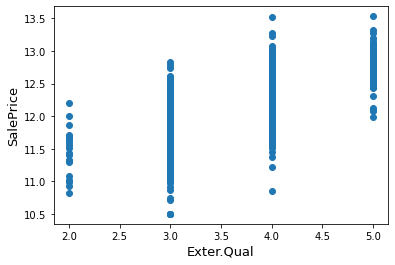

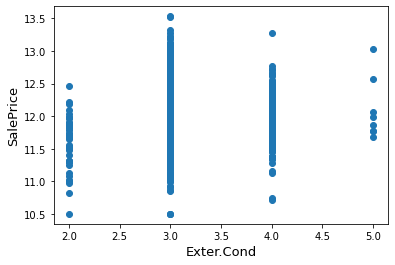

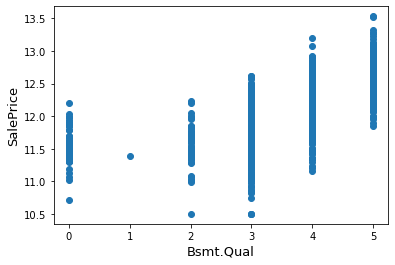

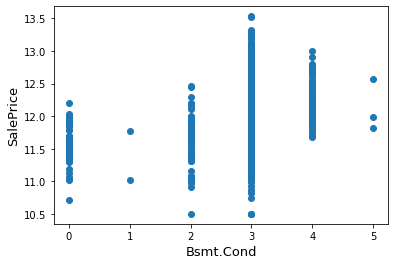

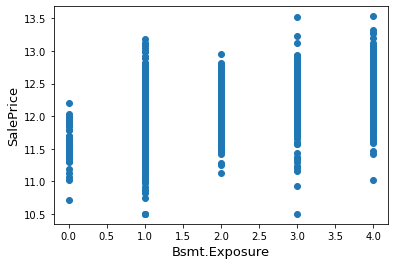

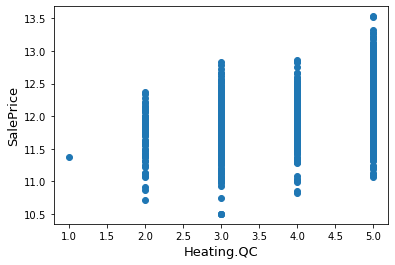

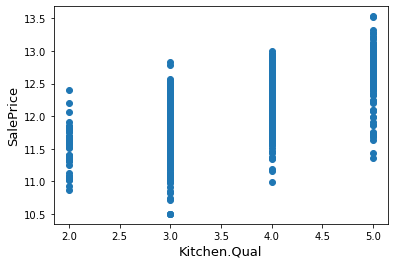

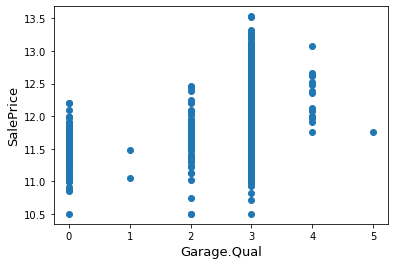

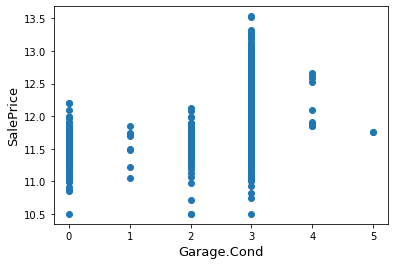

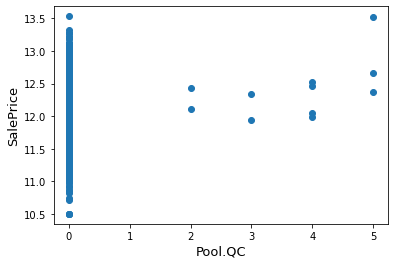

In [56]:
zamien_na_ciagle('Street')
zamien_na_ciagle('Central.Air')
zamien_na_ciagle('Alley')
zamien_na_ciagle('Land.Slope')
zamien_na_ciagle('Paved.Drive')
zamien_na_ciagle('Exter.Qual')
zamien_na_ciagle('Exter.Cond')
zamien_na_ciagle('Bsmt.Qual')
zamien_na_ciagle('Bsmt.Cond')
zamien_na_ciagle('Bsmt.Exposure')
zamien_na_ciagle('Heating.QC')
zamien_na_ciagle('Kitchen.Qual')
zamien_na_ciagle('Garage.Qual')
zamien_na_ciagle('Garage.Cond')
zamien_na_ciagle('Pool.QC')

# ONE HOT ENCODING

Okej, odsialiśmy już dane kategoryczne z wszystkich gdzie dało się zastosowac bardziej optymalne rozwiązanie. Pozostały nam zmienne gdzie rozbijemy sobie wartości na osobne kolumny. Przeanalizujmy je.

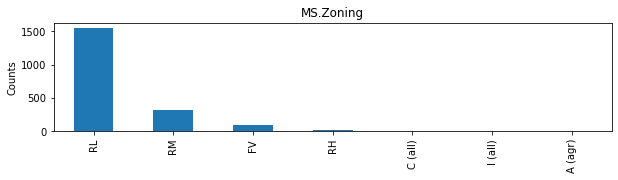

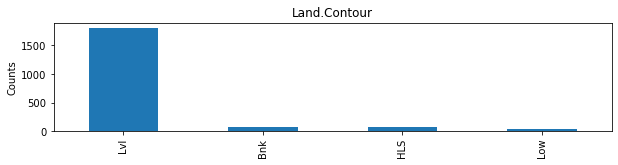

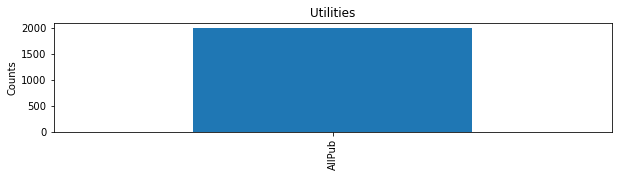

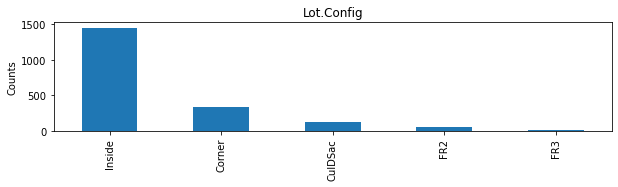

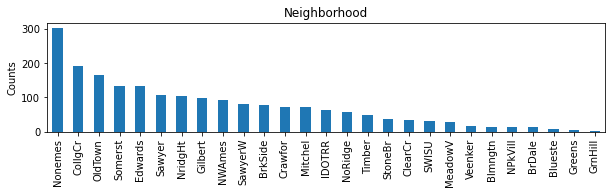

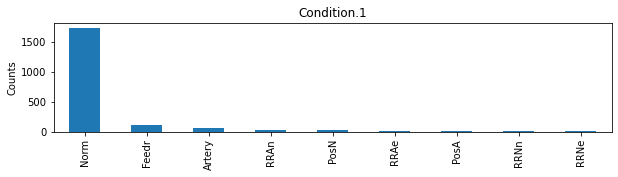

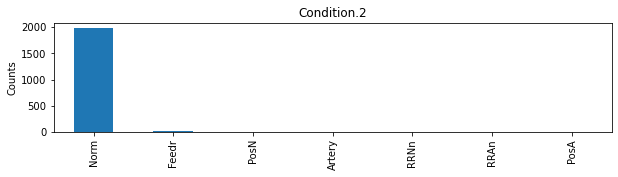

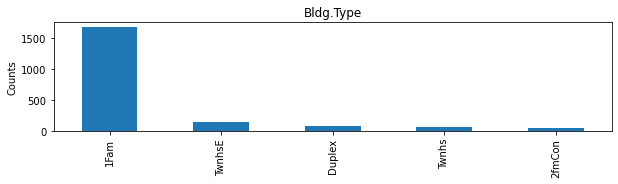

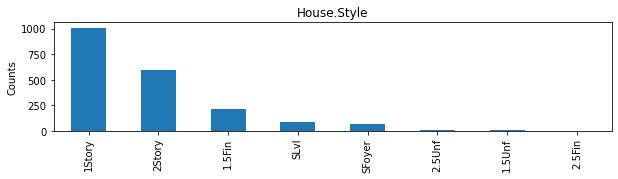

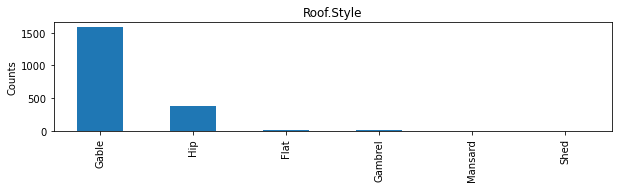

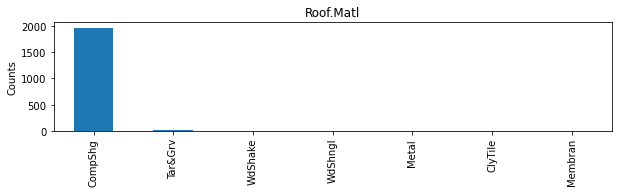

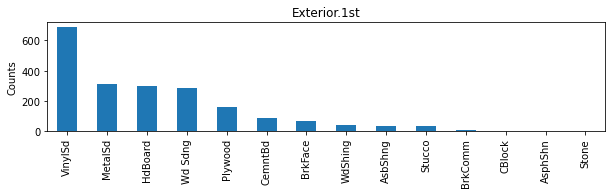

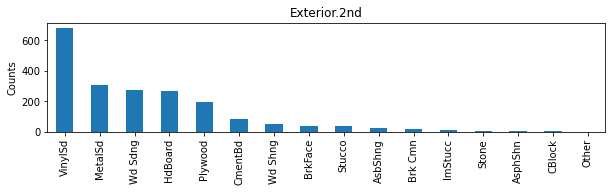

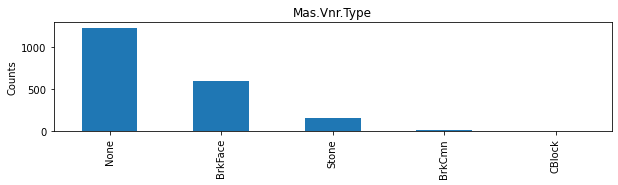

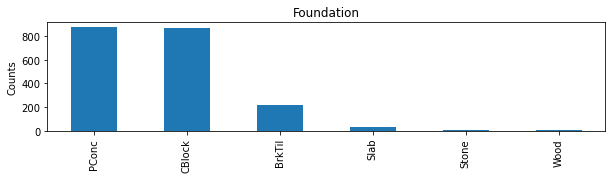

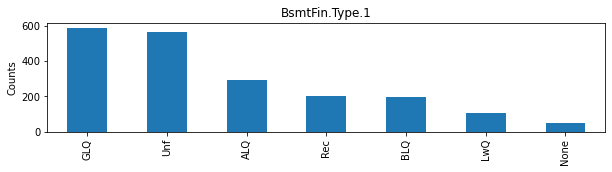

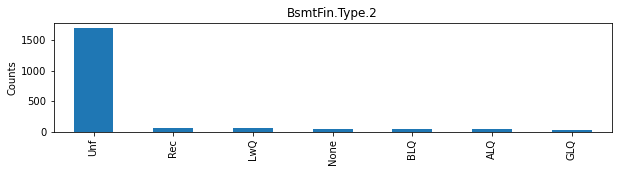

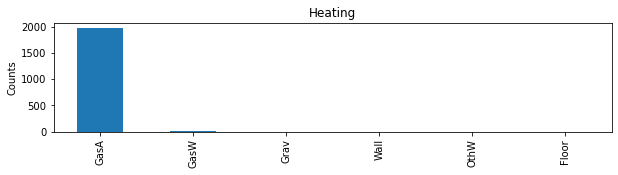

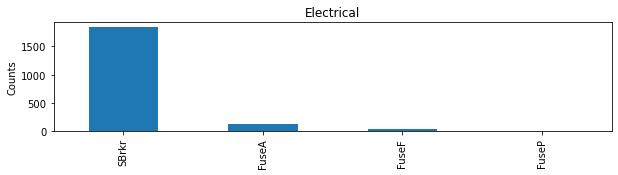

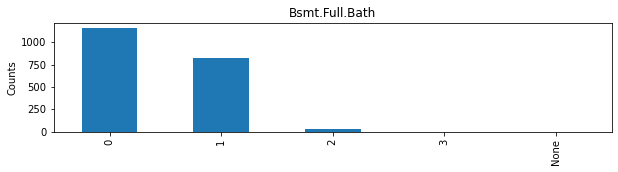

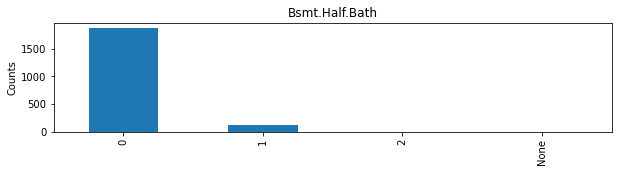

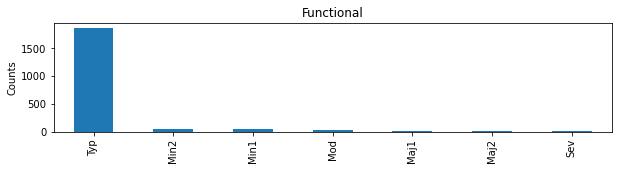

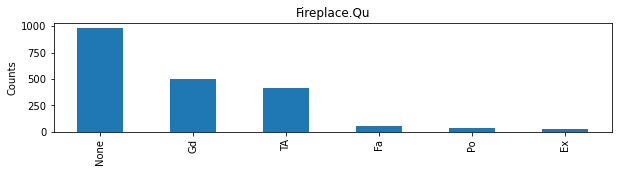

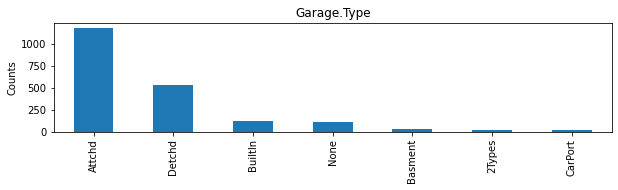

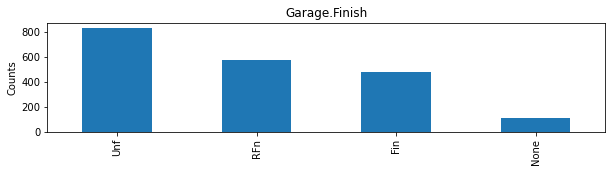

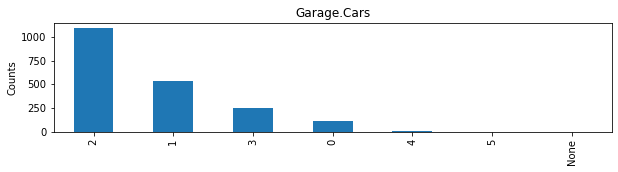

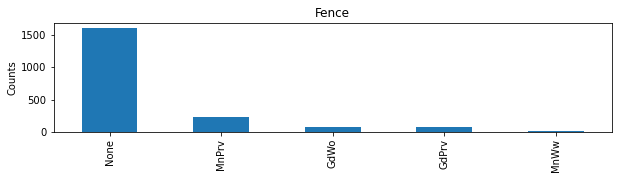

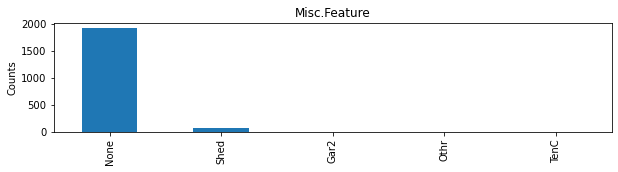

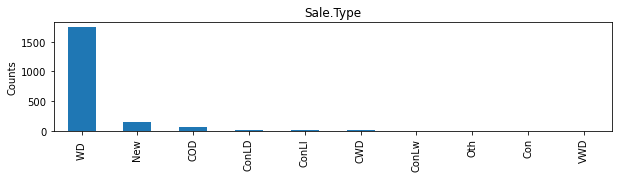

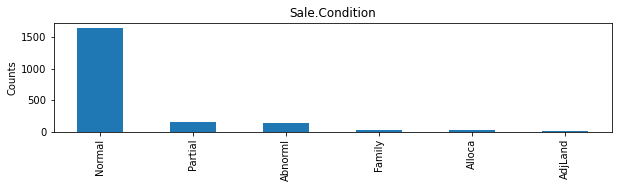

In [57]:
data_cat = data.select_dtypes(include=['object']).columns

for col in data_cat:
    data[col].value_counts().plot(kind='bar', title=col,figsize=(10, 2))
    plt.ylabel("Counts")
    plt.show()

Potencjalnie widzimy parę zmiennych gdzie jeżeli model nie będzie zwracał dobrych wartości można by się pokusić o połączenie paru wartości w jeden koszyk.

Zweryfikujemy wyniki modelu i zastanowimy się czy zobaczymy tu znaczny uzysk.
Merytorycznie widzę potencjalnie błąd logiczny takiego rozwiązania np. przy zmiennej dotyczącej rodzaju ogrzewania nie możemy wrzucić w jeden koszyk nietypowego rozwiązania i np. braku ogrzewania (przykład nie wprost z danych ale dla zaobrazowania idei).
Te bardzo nietypowe wartości mogą bardzo różnicować dane.

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS.SubClass      2000 non-null   int64  
 1   MS.Zoning        2000 non-null   object 
 2   Lot.Frontage     2000 non-null   int32  
 3   Lot.Area         2000 non-null   int64  
 4   Street           2000 non-null   int32  
 5   Alley            2000 non-null   int32  
 6   Lot.Shape        2000 non-null   int64  
 7   Land.Contour     2000 non-null   object 
 8   Utilities        2000 non-null   object 
 9   Lot.Config       2000 non-null   object 
 10  Land.Slope       2000 non-null   int32  
 11  Neighborhood     2000 non-null   object 
 12  Condition.1      2000 non-null   object 
 13  Condition.2      2000 non-null   object 
 14  Bldg.Type        2000 non-null   object 
 15  House.Style      2000 non-null   object 
 16  Overall.Qual     2000 non-null   int64  
 17  Overall.Cond  

Dodatkowo musimy zrobić one hot econder na zmiennej YrSold, przetrzymywanie jej jako ciaglej jest bledne - róznice pomiędzy latami nie mogą być traktowane jako zmienna. Tutaj kluczowy jest stan ekonomii (kursy, parametry rynku, nastroje) w danym roku i jak wpływa na kształtowanie się cen w danym koszyku.

W przypadku złego wyniku modelu potencjalne miejsce do przyjrzenia się jak różnicą się wartości w poszczególnych latach i zastanowienie się nad poprawą rozwiązania.

In [59]:
data['YrSold'] = data['Yr.Sold'].apply(lambda x: str(x))

In [60]:
data['YrSold'] = data['YrSold'].astype(object)

In [61]:
data = pd.get_dummies(data).reset_index(drop=True)
data.shape

(2000, 272)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 272 entries, MS.SubClass to YrSold_2010
dtypes: float64(1), int32(23), int64(26), uint8(222)
memory usage: 1.0 MB


# DANE NUMERYCZNE

Wiemy, że nasze zmienne numeryczne ciagle sa w int64, nowe zmienne w int32, one hot encoding w uint8, wyniki we float,
mozemy wiec analizowac tylko wybrany dtype

In [63]:
rozklad = data.describe(include=['int64','int32']).T
nulle = pd.DataFrame(data.isna().sum())
nulle.columns = ["null"]
rozklad = rozklad.join(nulle)
rozklad

,count,mean,std,min,25%,50%,75%,max,null
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0,0
Lot.Frontage,2000.0,57.8415,33.748020,0.0,43.00,63.0,78.00,313.0,0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0,0
Street,2000.0,0.9960,0.063135,0.0,1.00,1.0,1.00,1.0,0
Alley,2000.0,0.0925,0.366075,0.0,0.00,0.0,0.00,2.0,0
Lot.Shape,2000.0,2.5970,0.578583,0.0,2.00,3.0,3.00,3.0,0
Land.Slope,2000.0,1.9430,0.260355,0.0,2.00,2.0,2.00,2.0,0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0,0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0,0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0,0


Widzimy parę rzeczy które można spokojnie poprawić - przyłożyć lgarytm do pozytywnie skośnych danych, zamienić wartości z danych rocznych korygując je o rok danych (czylki odejmując je od 2010) - tak naprawdę chodzi o odpowiednie ocenienie bardzo nowych mieszkan które powinny tracić na wartości szybciej i powinny mieć znacznie lepsze pozostałe parametry - różnica zmiennej ciągłej nie pokaże odpowiedniej róznicy między 2 i 4 letnim mieszkaniem a 25 i 27 letnim (2008 vs 2010 a 1985 i 1987 odpowiednio na zmiennej oryginalnej).

In [64]:
def popraw_rok(name):
    data[name] = 2010 - data[name]
    
popraw_rok('Year.Built')
popraw_rok('Year.Remod.Add')
popraw_rok('Garage.Yr.Blt')

Teraz pora na badanie skośności

In [65]:
numeric_dtypes = ['int32', 'int64', 'float64']
numeric = []
for i in data.columns:
    if data[i].dtype in numeric_dtypes:
        numeric.append(i)

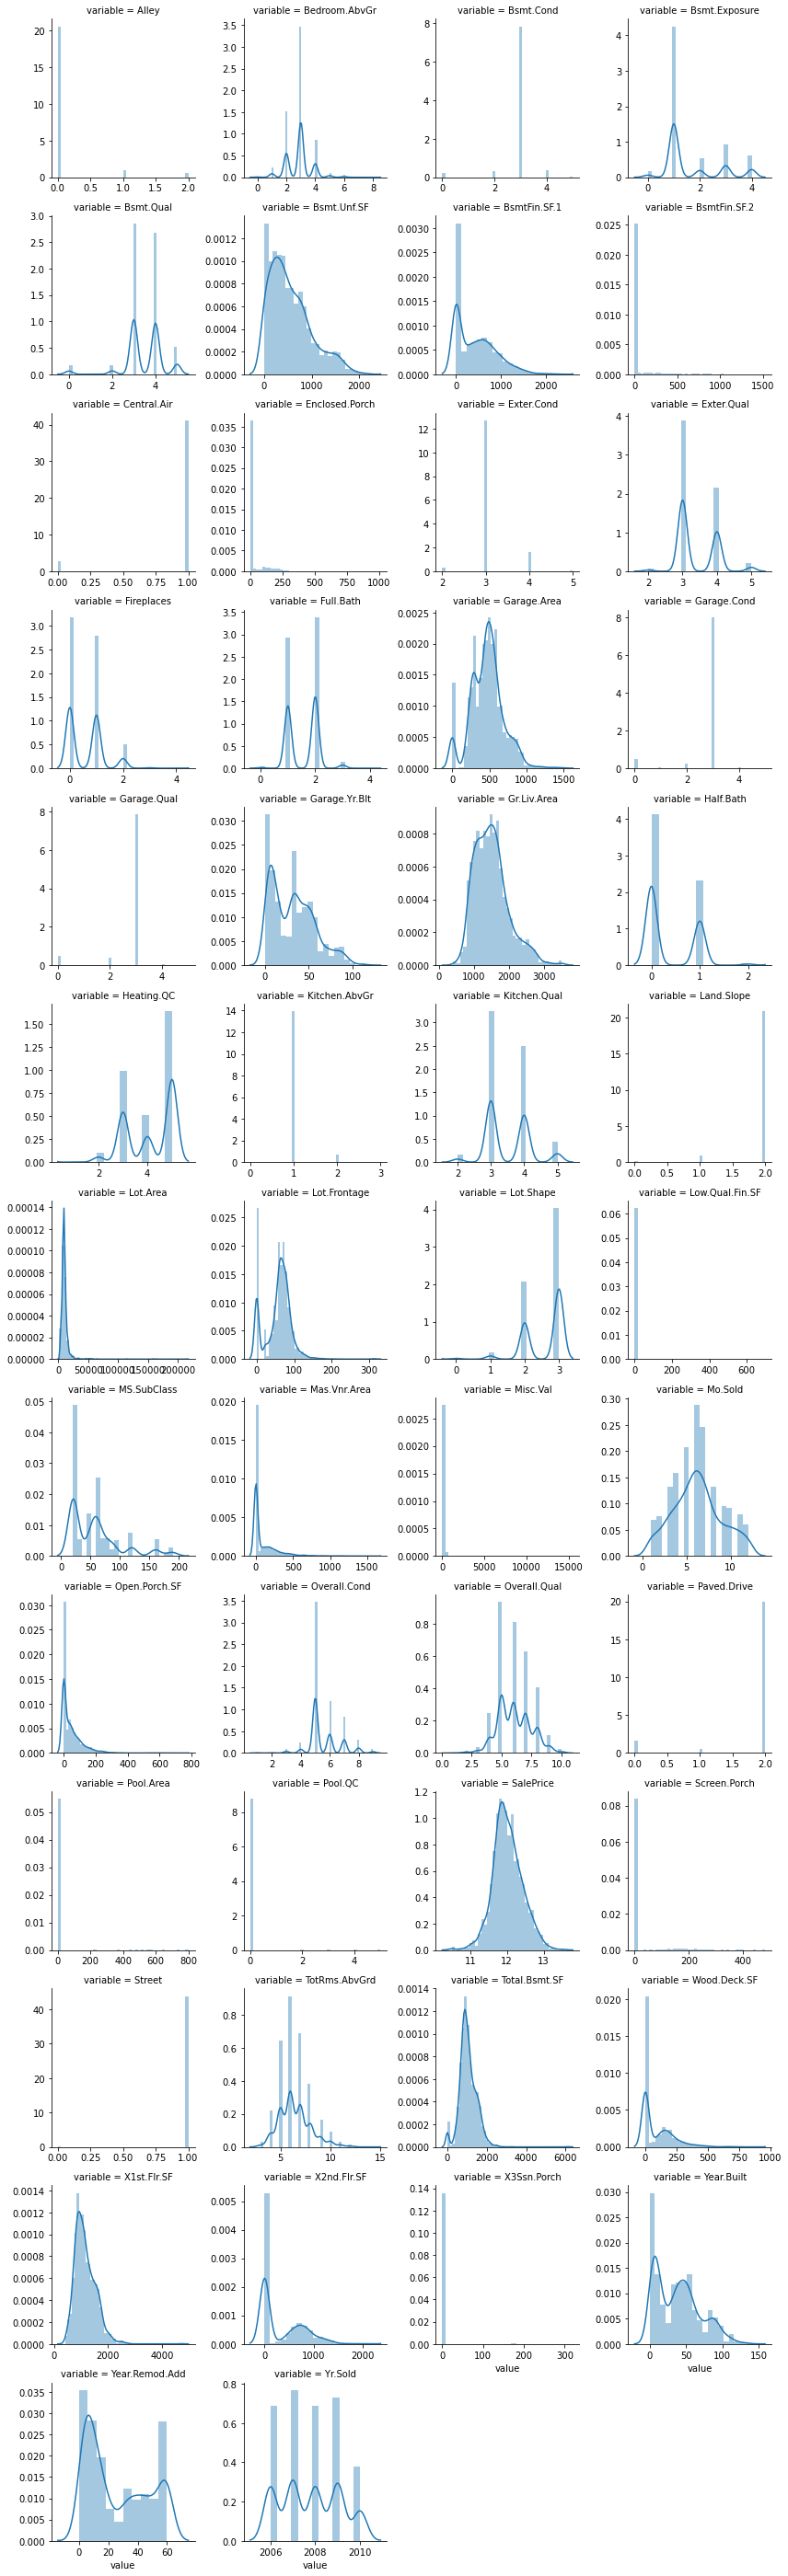

In [66]:
# Grid of distribution plots of all numerical features
f = pd.melt(data, value_vars=sorted(numeric))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

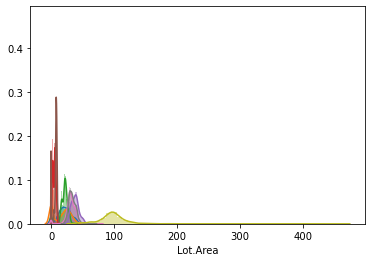

In [67]:
# za względu na problemy z 0 przy wielu zmiennych uzywam pierwiastka zamiast logarytmu akceptujac, ze dziala gorzej
# można by próbować przesuwać wartości o stałą lub zakodować odpowiednio 0 ale popsuje to jakośc danych

def popraw_krzywizne(name):
    data[name] = np.sqrt(data[name])
    sns.distplot(data[name]);

popraw_krzywizne('Bsmt.Unf.SF')
popraw_krzywizne('BsmtFin.SF.1')
popraw_krzywizne('Garage.Area')
popraw_krzywizne('Garage.Yr.Blt')
popraw_krzywizne('Gr.Liv.Area')
popraw_krzywizne('Lot.Frontage')
popraw_krzywizne('Total.Bsmt.SF')
popraw_krzywizne('X1st.Flr.SF')
popraw_krzywizne('Lot.Area')

Standardowy check dataframe po przetworzeniach

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 272 entries, MS.SubClass to YrSold_2010
dtypes: float64(10), int32(17), int64(23), uint8(222)
memory usage: 1.1 MB


# PRE MODELOWANIE

Pora wydzielić zmienną celu, podzielić zbiór na dane testowe i treningowe, ustawić kfold to cross validacji i przygotować pipepline dla modeli

In [69]:
y = data['SalePrice']
data.drop('SalePrice', axis=1, inplace=True)
X = data

In [70]:
kf = model_selection.KFold(n_splits=5, random_state=40, shuffle=True)

In [71]:
X

,MS.SubClass,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Slope,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.SF.1,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating.QC,Central.Air,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Fireplaces,Garage.Yr.Blt,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Misc.Val,Mo.Sold,Yr.Sold,MS.Zoning_A (agr),MS.Zoning_C (all),MS.Zoning_FV,MS.Zoning_I (all),MS.Zoning_RH,MS.Zoning_RL,MS.Zoning_RM,Land.Contour_Bnk,Land.Contour_HLS,Land.Contour_Low,Land.Contour_Lvl,Utilities_AllPub,Lot.Config_Corner,Lot.Config_CulDSac,Lot.Config_FR2,Lot.Config_FR3,Lot.Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_Nonemes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition.1_Artery,Condition.1_Feedr,Condition.1_Norm,Condition.1_PosA,Condition.1_PosN,Condition.1_RRAe,Condition.1_RRAn,Condition.1_RRNe,Condition.1_RRNn,Condition.2_Artery,Condition.2_Feedr,Condition.2_Norm,Condition.2_PosA,Condition.2_PosN,Condition.2_RRAn,Condition.2_RRNn,Bldg.Type_1Fam,Bldg.Type_2fmCon,Bldg.Type_Duplex,Bldg.Type_Twnhs,Bldg.Type_TwnhsE,House.Style_1.5Fin,House.Style_1.5Unf,House.Style_1Story,House.Style_2.5Fin,House.Style_2.5Unf,House.Style_2Story,House.Style_SFoyer,House.Style_SLvl,Roof.Style_Flat,Roof.Style_Gable,Roof.Style_Gambrel,Roof.Style_Hip,Roof.Style_Mansard,Roof.Style_Shed,Roof.Matl_ClyTile,Roof.Matl_CompShg,Roof.Matl_Membran,Roof.Matl_Metal,Roof.Matl_Tar&Grv,Roof.Matl_WdShake,Roof.Matl_WdShngl,Exterior.1st_AsbShng,Exterior.1st_AsphShn,Exterior.1st_BrkComm,Exterior.1st_BrkFace,Exterior.1st_CBlock,Exterior.1st_CemntBd,Exterior.1st_HdBoard,Exterior.1st_MetalSd,Exterior.1st_Plywood,Exterior.1st_Stone,Exterior.1st_Stucco,Exterior.1st_VinylSd,Exterior.1st_Wd Sdng,Exterior.1st_WdShing,Exterior.2nd_AsbShng,Exterior.2nd_AsphShn,Exterior.2nd_Brk Cmn,Exterior.2nd_BrkFace,Exterior.2nd_CBlock,Exterior.2nd_CmentBd,Exterior.2nd_HdBoard,Exterior.2nd_ImStucc,Exterior.2nd_MetalSd,Exterior.2nd_Other,Exterior.2nd_Plywood,Exterior.2nd_Stone,Exterior.2nd_Stucco,Exterior.2nd_VinylSd,Exterior.2nd_Wd Sdng,Exterior.2nd_Wd Shng,Mas.Vnr.Type_BrkCmn,Mas.Vnr.Type_BrkFace,Mas.Vnr.Type_CBlock,Mas.Vnr.Type_None,Mas.Vnr.Type_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFin.Type.1_ALQ,BsmtFin.Type.1_BLQ,BsmtFin.Type.1_GLQ,BsmtFin.Type.1_LwQ,BsmtFin.Type.1_None,BsmtFin.Type.1_Rec,BsmtFin.Type.1_Unf,BsmtFin.Type.2_ALQ,BsmtFin.Type.2_BLQ,BsmtFin.Type.2_GLQ,BsmtFin.Type.2_LwQ,BsmtFin.Type.2_None,BsmtFin.Type.2_Rec,BsmtFin.Type.2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Bsmt.Full.Bath_0,Bsmt.Full.Bath_1,Bsmt.Full.Bath_2,Bsmt.Full.Bath_3,Bsmt.Full.Bath_None,Bsmt.Half.Bath_0,Bsmt.Half.Bath_1,Bsmt.Half.Bath_2,Bsmt.Half.Bath_None,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fireplace.Qu_Ex,Fireplace.Qu_Fa,Fireplace.Qu_Gd,Fireplace.Qu_None,Fireplace.Qu_Po,Fireplace.Qu_TA,Garage.Type_2Types,Garage.Type_Attchd,Garage.Type_Basment,Garage.Type_BuiltIn,Garage.Type_CarPort,Garage.Type_Detchd,Garage.Type_None,Garage.Finish_Fin,Garage.Finish_None,Garage.Finish_RFn,Garage.Finish_Unf,Garage.Cars_0,Garage.Cars_1,Garage.Cars_2,Gara

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# MODELE

Sprawdzimy jakość podstawowych modeli regresyjnych przy doborze parametrów modeli z Grid Search (dodaję do listy parametrów dodatkowe tak długo aż wybrane parametry nie są skrajne)

In [73]:
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'elasticnet__alpha': [0.01, 0.05, 0.1, 0.5, 0.1, 10]},
                    cv=kf,
                    refit=True)
grid_1.fit(X_train, y_train)
grid_1.best_params_

{'elasticnet__alpha': 0.1, 'polynomialfeatures__degree': 2}

In [74]:
grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'lasso__alpha': [0.01, 0.1, 0.5, 1, 10]},
                    cv=kf,
                    refit=True)
grid_2.fit(X_train, y_train)
grid_2.best_params_

{'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}

In [75]:
grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.Ridge(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
                    cv=kf,
                    refit=True)
grid_3.fit(X_train, y_train)
grid_3.best_params_

{'polynomialfeatures__degree': 1, 'ridge__alpha': 10}

In [76]:
grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kf,
                    refit=True)
grid_4.fit(X_train, y_train)
grid_4.best_estimator_

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [77]:
grid_5 = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
                    cv=kf,
                    refit=True)
grid_5.fit(X_train, y_train)
grid_5.best_estimator_

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
param_grid = {
    'n_estimators': [20,50,100, 150, 200],
    'max_depth':  [10, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    
}
rfc = RandomForestRegressor(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
grid_6 = GridSearchCV(estimator=rfc, 
                      param_grid=param_grid, 
                      cv= kf)
grid_6.fit(X_train, y_train)
grid_6.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=150, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

Przypisujemy wartości najlepszych estymatorów - przy parametrze refit=True mamy pewność, że z każdego modelu wybieramy najlepszy estymator

In [79]:
models = []
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('SVR', grid_5.best_estimator_))
models.append(('RF', grid_6.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

ElasticNet
R^2: 0.9016427752723465
Explained variance score: 0.9018040110610448
Median absolute error: 0.06415261664208316
Mean squared error: 0.01578162111419169
Mean absolute errors: 0.08912333546879873
Lasso
R^2: 0.9027683102982308
Explained variance score: 0.9030043166056713
Median absolute error: 0.0608033254431648
Mean squared error: 0.015601026680194169
Mean absolute errors: 0.0868510351619545
Ridge
R^2: 0.9207696997617221
Explained variance score: 0.920771079161516
Median absolute error: 0.06604571760154254
Mean squared error: 0.012712666330169476
Mean absolute errors: 0.08284204421792526
LR
R^2: 0.916331651929436
Explained variance score: 0.9163871735984198
Median absolute error: 0.06405388602125406
Mean squared error: 0.013424760328040354
Mean absolute errors: 0.0849838713122343
SVR
R^2: 0.023125448435317608
Explained variance score: 0.023667015356665377
Median absolute error: 0.25759595006079117
Mean squared error: 0.15674155194575431
Mean absolute errors: 0.307470295082267


In [80]:
d = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['ElasticNet','Lasso','Ridge','LR', 'SVR', 'RF'])
df

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.901643,0.901804,0.064153,0.015782,0.089123
1,Lasso,0.902768,0.903004,0.060803,0.015601,0.086851
2,Ridge,0.920770,0.920771,0.066046,0.012713,0.082842
3,LR,0.916332,0.916387,0.064054,0.013425,0.084984
4,SVR,0.023125,0.023667,0.257596,0.156742,0.307470
5,RF,0.884921,0.885056,0.063028,0.018465,0.094073


Jak widać wszystkie bardziej zaawansowane metody poradziły sobie ze zbiorem danych, najgorzej wypada czysta regresja liniowa.
Gdyby nie porównywalne wyniki pozstałych metod można by spróbować ulepszyć ja o skalowanie danych.

# ANALIZA WYNIKÓW

Najlepsze wyniki regresji daje Ridge i Lasso w zaleznosci od rozwazanych miar, zobaczmy po wykresach jak się oba zachowują

In [81]:
grid_3.best_estimator_.predict(X)

array([12.17733658, 11.60875162, 11.83250103, ..., 12.33461929,
       11.80667786, 12.10482992])

In [82]:
grid_2.best_estimator_.predict(X)

array([12.22652332, 11.6696055 , 11.8404022 , ..., 12.36991967,
       11.82864882, 12.12148242])

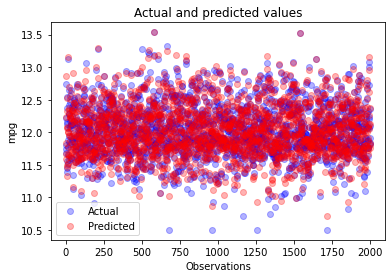

<Figure size 864x432 with 0 Axes>

In [83]:
_, ax = plt.subplots()
y_pred2 = grid_2.best_estimator_.predict(X)

ax.scatter(x = range(0, y.size), y=y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred2.size), y=y_pred2, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.figure(figsize=(12,6))
plt.show()

Text(0, 0.5, 'Frequency')

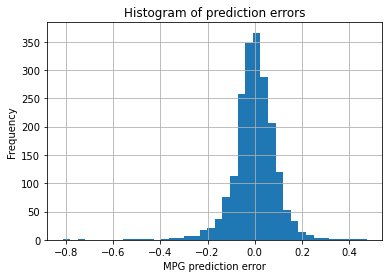

In [84]:
diff = y - y_pred2
diff.hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

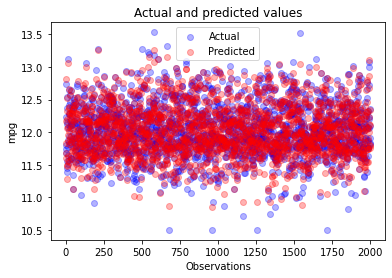

<Figure size 864x432 with 0 Axes>

In [85]:
_, ax = plt.subplots()
y_pred3 = grid_3.best_estimator_.predict(X)

ax.scatter(x = range(0, y.size), y=y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred3.size), y=y_pred3, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.figure(figsize=(12,6))
plt.show()

Text(0, 0.5, 'Frequency')

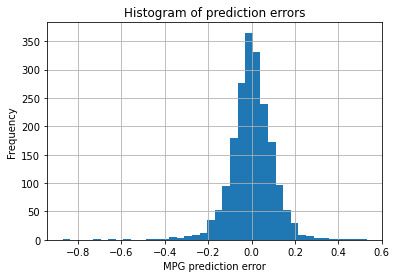

In [86]:
diff = y - y_pred3
diff.hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

Pamiętamy ze skalowaliśmy wartości logarytmem, zobaczmy jak to wygląda na cenach w dolarach sprawdzając ile wynosi średnia wartość mieszkania

In [87]:
y_fix = math.e**y
y_pred_lasso_fit = math.e**y_pred2
y_pred_ridge_fit = math.e**y_pred3

In [88]:
y_fix.mean()

180254.53300534846

In [89]:
y_pred_lasso_fit.mean()

180506.9456455601

In [90]:
y_pred_ridge_fit.mean()

179372.78031655104

Text(0, 0.5, 'Frequency')

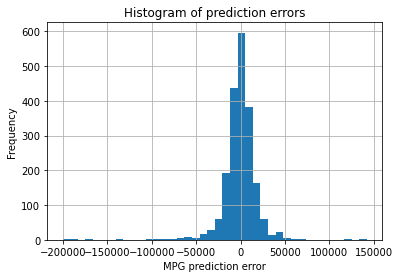

In [91]:
diff = y_fix  - y_pred_lasso_fit
diff.hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

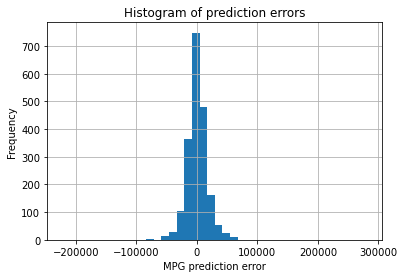

In [92]:
diff = y_fix  - y_pred_ridge_fit
diff.hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

Dziękuję za uwagę :)